# 1 - Importing all the required modules and the functions.py file that contains our custom made functions

In [ ]:
import os
import h5py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import importlib
import getpass
import glob
import seaborn as sns
import functions
import spectrogram_plotting_functions
import plotting_styles
import scipy.stats
import mne_connectivity
importlib.reload(functions) #loads our custom made functions.py file
importlib.reload(spectrogram_plotting_functions)
importlib.reload(plotting_styles)


# 2 - Loading the data files

This code fetches the current 'user' by using getpass. Then it sets the basepath, loads the files and specifies the savepath. Note that the basepath, files and savepath need to be changed depending on where you have kept the files and where you want the results to be stored. In this case, I have set it up to be in a particular folder in my Dropbox account, which is stored locally.

In [ ]:
#Fetch the current user
user= (getpass.getuser())
print("Hello", user)

#Set the basepath, savepath and load the data files
base='C:\\Users\\{}\\Dropbox\\CPLab'.format(user)
files = glob.glob(base+'\\all_data_mat\\*.mat')
savepath = base+'\\results\\'
print(files)

all_bands_dict = {'total':[1,100], 'beta':[12,20], 'gamma':[30,80], 'theta':[4,12]}


# 3 Extracting band data around events and saving it in a dataframe

1.  The keyboard dict maps the keyboard codes that were the annotation in .mat files to their meanings. '98':'b' is the beginning of a black trial,'119':'w' is the beginning of a white trial,'120':'nc' is the beginning of a no context trial,'49':'1' signifies a correct dig by the rat,'48':'0' signifies an incorrect dig by the rat.
2. Then we initialize some empty dictionaries and dataframes to store data.
3. Then we start looping through each of the data files.
4. We first get the basename of the file using `os.path.basename(file)`
5. We split the basename using `os.path.splitext(base_name)` , and use  `functions.exp_params` to get the date of the task, rat id and the task the rat was doing

In [42]:

keyboard_dict={'98':'b','119':'w','120':'nc','49':'1','48':'0'} #specifying the map of keyboard annotations to their meanings.
all_bands={'total':[1,100],'beta':[12,30], 'gamma':[30,80], 'theta':[4,12]}

#files=[f'C:\\Users\\{user}\\Dropbox\\CPLab\\all_data_mat_filtered\\20230615_dk6_BW_context_day1.mat', f'C:\\Users\\{user}\\Dropbox\\CPLab\\all_data_mat\\20230626_dk6_BW_nocontext_day1.mat'] #This is just for testing purposes

#Initializing a few empty things to store data
events_codes_all = {}
compiled_data_all_epochs = []
compiled_data_list=[]
baseline_lfp_all = []
normalization_comparison_all = []
for file in files: #Looping through data files
    
    ## Get the date, mouse_id and task from the file name
    base_name = os.path.basename(file)
    base_name, _ = os.path.splitext(base_name)
    date, mouse_id, task=functions.exp_params(base_name) #Using a custom made function [see functions.py]
    print(date, mouse_id, task)
    if task == 'nocontextday2' or task == 'nocontextos2':
        task = 'nocontext'
    if task =='nocontext':
        continue
    f=h5py.File(file, 'r')  ## Open the data file
    channels = list(f.keys()) ## Extract channels list from the data file
    print(channels)
    if not any("AON" in channel or "vHp" in channel for channel in channels):
        continue
    events,reference_electrode=functions.get_keyboard_and_ref_channels(f,channels)

    events_codes=np.array(events['codes'][0]) #saving the keyboard annotations of the events (door open, door close etc.)
    events_times=np.array(events['times'][0]) #saving when the events happened
    events_codes_all[base_name] = events_codes #saving the codes in a dictionary to be analyzed later for events other than the ones in our keyboard_dict map
    
    #Generating epochs from events (epochs are basically start of a trial and end of a trial)
    epochs=functions.generate_epochs_with_first_event(events_codes, events_times)

    # task Start time
    first_event=events_times[0]
    #finding global start and end time of all channels, since they start and end recordings at different times
    global_start_time, global_end_time=functions.find_global_start_end_times(f,channels)
    
    ## Reference electrode finding and padding
    reference_time = np.array(reference_electrode['times']).flatten()
    reference_value = np.array(reference_electrode['values']).flatten()
    padd_ref_data,padded_ref_time=functions.pad_raw_data_raw_time(reference_value,reference_time,global_start_time,global_end_time,sampling_rate=2000)


    for channeli in channels:
        if "AON" in channeli or  "vHp" in channeli :
            
            channel_id=channeli
            # Extracting raw data and time
            data_all=f[channeli]
            raw_data=np.array(data_all['values']).flatten()
            raw_time = np.array(data_all['times']).flatten()
            sampling_rate = 2000
            print(channel_id)
            print(raw_data.shape, raw_time.shape, sampling_rate)
            
            padded_data,padded_time=functions.pad_raw_data_raw_time(raw_data,raw_time,global_start_time,global_end_time,sampling_rate)
            subtracted_data = padded_data - padd_ref_data
            raw_data=subtracted_data
            notch_filtered_data = functions.iir_notch(raw_data, sampling_rate, 60)
            
            data_before, time, baseline_mean, baseline_std=functions.baseline_data_normalization(notch_filtered_data, raw_time, first_event, sampling_rate)
            first_event_index=np.where(raw_time>first_event)[0][0]

            baseline_row=[mouse_id,task,channel_id,np.array(data_before)]
            baseline_lfp_all.append(baseline_row)
            normalized_data=notch_filtered_data

            #Saving non-normalized data and normalized data for plotting
            normalization_row=[mouse_id,task,channel_id,[notch_filtered_data[first_event_index:first_event_index+30*sampling_rate]],np.mean(data_before),np.std(data_before),[normalized_data[first_event_index:first_event_index+30*sampling_rate]]]
            normalization_comparison_all.append(normalization_row)


            for i,epochi in enumerate(epochs):
                
                compiled_data = pd.DataFrame() # Initializing a dataframe to store the data of a single epoch

                door_timestamp = epochi[0][0]
                trial_type = epochi[0][1]
                dig_type = epochi[1, 1]
                dig_timestamp = epochi[1, 0]
                print(door_timestamp,trial_type,dig_timestamp,dig_type)
                
                
                data_complete_trial=functions.extract_complete_trial_data(notch_filtered_data,time,door_timestamp,dig_timestamp,sampling_rate)
                data_trial_before, data_trial_after=functions.extract_door_data(notch_filtered_data,time,door_timestamp,sampling_rate)
                data_dig_before, data_dig_after=functions.extract_dig_data(notch_filtered_data,time,dig_timestamp,sampling_rate)
                epoch_data = [data_complete_trial, data_trial_before, data_trial_after, data_dig_before, data_dig_after]
                epoch_data = [functions.zscore_event_data(x, baseline_mean, baseline_std) for x in epoch_data]

                compiled_data = {
                    'rat': mouse_id,
                    'date': date,
                    'task': task,
                    'channel': channel_id,
                    'trial': i,
                    'timestamps': [door_timestamp, dig_timestamp],
                    'side': keyboard_dict[str(int(trial_type))],
                    'correct?': keyboard_dict[str(int(dig_type))],
                    'first 30 seconds power': functions.calculate_power_1D(data_before),
                    'time': time,
                    'complete_trial': epoch_data[0],
                    'pre_door': epoch_data[1],
                    'post_door': epoch_data[2],
                    'pre_dig': epoch_data[3],
                    'post_dig': epoch_data[4],
                    'around_door': np.append(epoch_data[1],epoch_data[2]),
                    'around_dig': np.append(epoch_data[3], epoch_data[4])
                }

                compiled_data_list.append(compiled_data)

compiled_data_all_epochs.extend(compiled_data_list)
compiled_data_all_epochs = pd.DataFrame(compiled_data_all_epochs)
compiled_data_all_epochs= compiled_data_all_epochs[compiled_data_all_epochs['task']!='nocontext']
baseline_lfp_all = pd.DataFrame(baseline_lfp_all, columns=['rat', 'task', 'channel', 'data'])
normalization_comparison_all = pd.DataFrame(normalization_comparison_all, columns=['rat', 'task', 'channel', 'non_normalized_data', 'baseline_mean', 'baseline_std', 'normalized_data'])   


20230529 dk1 nocontext
20230529 dk3 nocontext
20230529 dk5 nocontext
20230529 dk6 nocontext
20230531 dk1 nocontextday2
20230531 dk3 nocontextday2
20230531 dk5 nocontextday2
20230531 dk6 nocontextday2
20230609 dk1 BWnocontext
['LFP1_vHp', 'LFP2_vHp', 'LFP3_AON', 'LFP4_AON', 'Memory', 'Ref', 'Respirat', 'file']
LFP1_vHp
(3960487,) (3960487,) 2000
notch filter applied
normalizing data
101.713685 98.0 115.92368499999999 48.0
333.79768499999994 98.0 338.87168499999996 49.0
444.175685 98.0 446.85367999999994 49.0
501.75368 98.0 504.30367999999993 49.0
760.9496849999999 119.0 762.7096849999999 49.0
860.7156849999999 119.0 862.9756849999999 49.0
950.9996849999999 119.0 954.8776899999999 49.0
1030.4496849999998 98.0 1032.059685 49.0
1118.8436849999998 98.0 1120.763685 49.0
1222.2376849999998 98.0 1224.1076799999998 49.0
1292.675685 98.0 1297.08369 48.0
1376.743685 119.0 1380.1036849999998 49.0
1467.2696799999999 119.0 1469.7196849999998 49.0
1533.645685 98.0 1536.311685 49.0
1603.7656849999998 

Waveform Analysis

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats

rat_list=list(np.unique(compiled_data_all_epochs['rat']))
window = [-2, 2]  # Set the window for the waveform

#band = 'total'  # Insert the band of interest
tasks = ['BWcontext', 'BWnocontext']
areas=['AON','vHp']
compiled_data_all_epochs['around_door'] = compiled_data_all_epochs['pre_door'] + compiled_data_all_epochs['post_door']
compiled_data_all_epochs['around_dig'] = compiled_data_all_epochs['pre_dig'] + compiled_data_all_epochs['post_dig']

for rati in rat_list:
    rat_dict = {}
    rat_data = compiled_data_all_epochs[compiled_data_all_epochs['rat'] == rati]
    rat_data['channel']=rat_data['channel'].apply(lambda x: 'AON' if 'AON' in x else 'vHp')
    rat_data = rat_data.reset_index(drop=True)
    fig = plt.figure(constrained_layout=True, figsize=(20, 10))    
    subfigs = fig.subfigures(2, 1)
    subfigs=subfigs.flatten()
    subfigs[1].set_facecolor('0.85')
    fig.suptitle(f'{rati}')
    
    for outerind, area in enumerate(areas):
        subfig=subfigs[outerind]
        axs = subfig.subplots(4, 2)
        
        rat_data_area = rat_data[rat_data['channel'] == area]
        rat_data_area = rat_data_area.reset_index(drop=True)   
    
        for i, band in enumerate(all_bands_dict.keys()):
            rat_data_band=rat_data_area.__deepcopy__()
            for col in (['around_door', 'around_dig']):
                rat_data_band[col] = rat_data_area[col].apply(lambda x: functions.freq_band(x, all_bands_dict[band][0], all_bands_dict[band][1], 2000))

            rat_data_band_grouped = rat_data_band.groupby(['task', 'channel'])
            for (task, channel), group in rat_data_band_grouped:
                group=group.reset_index(drop=True)
                print(group.shape)
                #group['around_dig']=np.concatenate([group['pre_dig'], group['post_dig']], axis=1)
                for j, col in enumerate(['around_door', 'around_dig']):
                    data = np.array(group[col])
                    data_mean = np.mean(data, axis=0)
                    data_sem = scipy.stats.sem(data, axis=0)
                    time_axis = np.linspace(-2, 2, len(data_mean))
                    ax = axs[i, j]
                    ax.set_title(f'{band} {channel} {col}')
                    ax.plot(time_axis, data_mean, color=plotting_styles.colors[task])
                    ax.fill_between(time_axis, data_mean - data_sem, data_mean + data_sem, alpha=0.2, color=plotting_styles.colors[task])
                    ax.vlines(0, ax.get_ylim()[0], ax.get_ylim()[1], color='k', linestyle='--')
    #fig.savefig(os.path.join(savepath,f' LFP_waveform{rati}'), dpi=300)
    plt.show()
    #plt.close(fig)

Average waveform

In [ ]:
waveform_data = compiled_data_all_epochs.copy()
waveform_data['channel'] = waveform_data['channel'].apply(lambda x: 'AON' if 'AON' in x else 'vHp')
waveform_data = waveform_data.reset_index(drop=True)
fig = plt.figure(constrained_layout=True, figsize=(20, 10))
subfigs = fig.subfigures(2, 1)
subfigs=subfigs.flatten()
subfigs[1].set_facecolor('0.85')
fig.suptitle(f'Waveform')

for i, band in enumerate(all_bands_dict.keys()):
    print(band)

waveform_data_grouped = waveform_data.groupby(['task', 'channel'])
for outerind, area in enumerate(areas):
    subfig=subfigs[outerind]
    axs = subfig.subplots(4, 2)
    waveform_data_area = waveform_data[waveform_data['channel'] == area]
    waveform_data_area = waveform_data_area.reset_index(drop=True)
    
    for i, band in enumerate(all_bands_dict.keys()):
        for col in (['around_door', 'around_dig']):
            waveform_data_area[col+'_'+band] = waveform_data_area[col].apply(lambda x: functions.freq_band(x, all_bands_dict[band][0], all_bands_dict[band][1], 2000))

        data = waveform_data_area[[f'around_door_{band}', f'around_dig_{band}']]
        data_mean = data.groupby(waveform_data_area['task']).mean()
        data_sem = data.groupby(waveform_data_area['task']).sem()
        time_axis = np.linspace(-2, 2, len(data_mean.columns))
        for j, task in enumerate(tasks):
            ax = axs[i, j]
            ax.set_title(f'{band} {task}')
            ax.plot(time_axis, data_mean.loc[task], color=plotting_styles.colors[task])
            ax.fill_between(time_axis, data_mean.loc[task] - data_sem.loc[task], data_mean.loc[task] + data_sem.loc[task], alpha=0.2, color=plotting_styles.colors[task])
            ax.vlines(0, ax.get_ylim()[0], ax.get_ylim()[1], color='k', linestyle='--')
plt.show() 

# 4 Power Spectra Analysis


## 4.1 Baseline Power

### 4.1.1 Baseline Power Spectra

In [ ]:
import plotting_styles

importlib.reload(plotting_styles)

linestyle = plotting_styles.linestyles
colors = plotting_styles.colors

df= baseline_lfp_all.__deepcopy__()
df['channel']=df['channel'].apply(lambda x:'AON' if 'AON' in x else 'vHp')
channel_experiment_group=df.groupby(['task','channel'])
fig, ax = plt.subplots(figsize=(20, 10))
mean_dict={}
for channel, data in channel_experiment_group:
    print(channel)
    data_array=np.vstack(data['data'].to_numpy())
    data_array_welch=scipy.signal.welch(data_array, fs=2000, nperseg=2000)
    data_array_welch_mean=np.mean(data_array_welch[1],axis=0)
    data_array_welch_std=np.std(data_array_welch[1],axis=0)
    mean_dict[channel[0] + '_' + channel[1] + '_mean'] = data_array_welch_mean
    mean_dict[channel[0] + '_' + channel[1] + '_std'] = data_array_welch_std
    ax.plot(data_array_welch[0],data_array_welch_mean, linestyle=linestyle[channel[1]], color=colors[channel[0]], label=f'{channel[0]} {channel[1]}')
    ax.fill_between(data_array_welch[0],data_array_welch_mean-data_array_welch_std,data_array_welch_mean+data_array_welch_std, alpha=0.1, color=colors[channel[0]])
    ax.set_xlim(0,100)
    ax.legend()
    ax.set_title('Baseline LFP Power Spectrum')
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Power (dB)')
#    ax.set_yscale('log')
mean_dict['frequency']=data_array_welch[0]
mean_df=pd.DataFrame(mean_dict)
mean_df.to_csv(savepath+'baseline_lfp_power_spectrum.csv')
plt.savefig(savepath+'baseline_lfp_power_spectrum.png')
plt.show()

### 4.2.2 Baseline Power per band Boxplot

In [ ]:
importlib.reload(plotting_styles)

linestyles = plotting_styles.linestyles
colors = plotting_styles.colors
brain_areas = ['AON','vHp']
df= baseline_lfp_all.__deepcopy__()
df['data']=df['data'].apply(lambda x:scipy.signal.welch(x, fs=2000, nperseg=2000)[1])

for band_name, band_values in all_bands_dict.items():
    df[band_name+'_power']=df['data'].apply(lambda x:functions.get_band_power(x, band_values[0], band_values[1]))

writer=pd.ExcelWriter(savepath+'baseline_lfp_power_per_band.xlsx')
fig, axs = plt.subplots(1,2, figsize=(20, 10), sharey=True)
axs=axs.flatten()
for i, area in enumerate(brain_areas):
    data = df[df['channel'].str.contains(area)]
    data_melted = data.melt(id_vars=['rat','task','channel'], value_vars=['total_power','beta_power','gamma_power','theta_power'], var_name='band', value_name='power')
    sns.boxplot(data=data_melted, x='band', y='power', hue='task', hue_order=['BWcontext','BWnocontext'], palette=colors, showfliers=False, ax=axs[i])
    sns.stripplot(data=data_melted, x='band', y='power', hue='task', hue_order=['BWcontext','BWnocontext'], palette=colors, dodge=True, alpha=0.5, jitter=0.2, ax=axs[i], linewidth=1, legend=False )
#    axs[i].set_yscale('log')
    axs[i].set_title(f'Baseline {area} Power per Band')
    axs[i].set_xlabel('Band')
    axs[i].set_ylabel('Power uV^2')
    axs[i].legend()
    axs[i].set_xticks(([0,1,2,3]),list(all_bands_dict.keys()))
    data_melted.to_excel(writer, sheet_name=area)
writer.close()
plt.savefig(savepath+'baseline_lfp_power_per_band.png')
plt.show()

Now we will plot the power spectra for each rat and the mean power spectra

In [ ]:
power_df=compiled_data_all_epochs.__deepcopy__()
power_df.iloc[:,-5:]=power_df.iloc[:,-5:].applymap(lambda x: scipy.signal.welch(x, fs=2000, nperseg=2000)[1])
#power_df['channel']=power_df['channel'].apply(lambda x: 'AON' if 'AON' in x else 'vHp')

We will plot the power spectra for the complete trial

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(20, 10), sharex=True, sharey=True)
axs=axs.flatten()
fig.suptitle('Power Spectral Density')
linestyles = {'AON': '-', 'vHp': '--'}

for i,rati in enumerate(rat_list):
    rat_data=power_df[power_df['rat']==rati]
    rat_data=rat_data.reset_index(drop=True)
    rat_data_grouped=rat_data.groupby(['task','channel'])
    for (task, channel),group in rat_data_grouped:
        print(task, channel)
        group=group.reset_index(drop=True)
        col='complete_trial'
        data = np.array(group[col])
        data_mean = np.mean(data, axis=0)
        data_sem = scipy.stats.sem(data, axis=0)
        freq = np.linspace(0, 1000, len(data_mean))        
        ax = axs[i]
        ax.set_title(f'{rati}')
        ax.plot(freq, data_mean, color=colors[task], linestyle=linestyles[channel])
        ax.fill_between(freq, data_mean - data_sem, data_mean + data_sem, alpha=0.2, color=colors[task])
        ax.set_xlim(0, 100)

4.2 Average Power Spectra across all rats

4.3 Event Power Spectra individual Rats

4.4 Average event power spectra across all rats

In [ ]:
events_list=['pre_door','post_door','pre_dig','post_dig']
fig, axs=plt.subplots(2,2, figsize=(20,10), sharex=True, sharey=True)
axs=axs.flatten()
writer=pd.ExcelWriter(savepath+'events_power_spectral_density.xlsx')
for i, event in enumerate(events_list):

    data = power_df[['rat','task','channel',event]]
    data['channel']=data['channel'].apply(lambda x: 'AON' if 'AON' in x else 'vHp')
    data_groups=data.groupby(['task','channel'])
    mean_data_dict={}
    for (task, channel), group in data_groups:
        group=group.reset_index(drop=True)
        data = np.array(group[event])
        data_mean = np.mean(data, axis=0)
        data_sem = scipy.stats.sem(data, axis=0)
        mean_data_dict[task+'_'+channel+'_mean']=data_mean
        mean_data_dict[task+'_'+channel+'_sem']=data_sem
        freq = np.linspace(0, 1000, len(data_mean))
        ax = axs[i]
        ax.set_title(f'{event}')
        ax.plot(freq, data_mean, color=plotting_styles.colors[task], linestyle=plotting_styles.linestyles[channel])
        ax.fill_between(freq, data_mean - data_sem, data_mean + data_sem, alpha=0.2, color=plotting_styles.colors[task])
        ax.set_xlim(0, 100)
        ax.set_xlabel('Frequency (Hz)')
        ax.set_ylabel('Power (dB)')
    mean_df=pd.DataFrame(mean_data_dict)
    mean_df.to_excel(writer, sheet_name=event)
writer.close()
plt.savefig(savepath+'events_power_spectral_density.png')
plt.show()




4.5 Power Boxplots

In [ ]:
import seaborn as sns
boxplot_df=compiled_data_all_epochs.__deepcopy__()
boxplot_df.iloc[:,-5:]=boxplot_df.iloc[:,-5:].applymap(lambda x: scipy.signal.welch(x, fs=2000, nperseg=2000)[1])

bands_dict = {'beta': [12, 30], 'gamma': [30, 80], 'theta': [4, 12], 'total': [1, 100]}
for col in boxplot_df.columns[-5:]:
    for band, (band_start, band_end) in bands_dict.items():
        boxplot_df[band + '_' + col] = boxplot_df[col].apply(lambda x: functions.get_band_power(x, band_start, band_end))

boxplot_df['unique_id'] = boxplot_df['rat'] + '_' + boxplot_df['task']+ '_' + boxplot_df['date']

In [ ]:


events_list = ['pre_door', 'post_door', 'pre_dig', 'post_dig']
boxplot_df = boxplot_df.drop(columns=events_list)
print(boxplot_df.columns)


In [ ]:

fig, axs = plt.subplots(2, 2, figsize=(20, 10), sharex=True, sharey=True)
axs = axs.flatten()
all_boxplot_df=boxplot_df.__deepcopy__()

all_boxplot_df['channel'] = all_boxplot_df['channel'].apply(lambda x: 'AON' if 'AON' in x else 'vHp')
aon_channels=all_boxplot_df[all_boxplot_df['channel']=='AON']
vhp_channels=all_boxplot_df[all_boxplot_df['channel']=='vHp']
writer=pd.ExcelWriter(savepath+'events_power_per_band_vhp.xlsx')
for i, event in enumerate(events_list):
    area_df=aon_channels
    event_cols = [col for col in area_df.columns if event in col]
    print(event_cols)
    event_df = area_df[['rat', 'task', 'channel','trial', *event_cols]]
    event_df_grouped=event_df.groupby(['task','channel'])
    event_df_melted = pd.melt(event_df, id_vars=['rat', 'task', 'channel'], var_name='band', value_name='power')
    event_df_melted['band'] = event_df_melted['band'].apply(lambda x: x.split('_')[0])
    ax=axs[i]
    sns.violinplot(x='band',y='power',hue='task',hue_order=['BWcontext','BWnocontext'],data=event_df_melted, ax=ax)
    #sns.stripplot(x='band',y='power',hue='task',hue_order=['BWcontext','BWnocontext'],data=event_df,dodge=True,edgecolor='black',linewidth=1,jitter=True, legend=False, ax=ax, color=".3", size=2)

    axs[i].set_title(event)
    axs[i].set_yscale('log')
    #axs[i].set_ylim(1e-3, 1e3)
    axs[i].set_ylabel('Power (uV^2)')
    event_df_melted.to_excel(writer, sheet_name=event)
writer.close()
plt.savefig(savepath+'events_power_per_band_aon.png')
plt.show()


Taking mean across all trials

In [ ]:
mean_boxplot_df=boxplot_df.__deepcopy__()
unique_id_list=list(np.unique(mean_boxplot_df['unique_id']))
mean_data_list=[]

for unique_id in unique_id_list:
    unique_id_df=mean_boxplot_df[mean_boxplot_df['unique_id']==unique_id]
    unique_id_df_grouped=unique_id_df.groupby(['channel'])
    for channel, group in unique_id_df_grouped:
        print(channel)
        group=group.reset_index(drop=True)
        columns=group.columns[-21:-1]
        rat_id=group['rat'].iloc[0]
        task_id=group['task'].iloc[0]
        date_id=group['date'].iloc[0]
        channel_id=group['channel'].iloc[0]
        mean_data_dict={}
        for col in columns:
            data=np.array(group[col])
            data_mean=np.mean(data,axis=0)
            data_sem=scipy.stats.sem(data,axis=0)
            mean_data_dict[col+'_mean']=data_mean
            mean_data_dict[col+'_sem']=data_sem
        mean_data_dict['rat']=rat_id
        mean_data_dict['task']=task_id
        mean_data_dict['date']=date_id
        mean_data_dict['channel']=channel_id
        mean_data_list.append(mean_data_dict)
mean_df=pd.DataFrame(mean_data_list)
mean_df.drop(columns=['date'], inplace=True)
mean_df_melted=pd.melt(mean_df, id_vars=['rat','task','channel'], var_name='band', value_name='power')


mean_df_melted['band name']=mean_df_melted['band'].apply(lambda x: x.split('_')[0])
mean_df_melted['event']=mean_df_melted['band'].apply(lambda x: x.split('_')[1:3])
mean_df_melted['event']=mean_df_melted['event'].apply(lambda x: '_'.join(x))
mean_df_melted['type']=mean_df_melted['band'].apply(lambda x: x.split('_')[-1])
cols = list(mean_df_melted.columns)
cols.append(cols.pop(cols.index('power')))
mean_df_melted = mean_df_melted[cols]
mean_df_melted.drop(columns=['band'], inplace=True)
mean_df_melted_grouped=mean_df_melted.groupby(['event'])
writer=pd.ExcelWriter(savepath+'mean_across_trials_power.xlsx')
for event, group in mean_df_melted_grouped:
    print(event)
    group=group.reset_index(drop=True)
    group.to_excel(writer, sheet_name=event[0])
writer.close()
arealist=['AON','vHp']
for area in arealist:
    fig,axs=plt.subplots(2,2,figsize=(20,10))
    fig.suptitle(area + ' Power averaged across trials ')
    axs=axs.flatten()
    events=['pre_door','post_door','pre_dig','post_dig']
    for i,event in enumerate(events):
        ax=axs[i]
        ## Plotting AON mean power
        plotting_df=mean_df_melted[(mean_df_melted['channel'].str.contains(area)) & (mean_df_melted['type']=='mean') & (mean_df_melted['event']==event)] 
        sns.boxplot(x='band name',y='power',hue='task',data=plotting_df,ax=ax, showfliers=False)
        sns.stripplot(x='band name',y='power',hue='task',data=plotting_df,dodge=True,edgecolor='black',linewidth=1,jitter=True, legend=False, ax=ax, color=".3", size=2)
        #ax.set_yscale('log')
        ax.set_ylabel('Power (uV^2)')
        ax.set_title(event)
    plt.savefig(savepath+f'mean_power_across_trials_{area}.png')
    plt.show()

#mean_df=pd.DataFrame(mean_data_dict)

Taking a mean across channels


In [ ]:
mean_boxplot_df=boxplot_df.__deepcopy__()
unique_id_list=list(np.unique(mean_boxplot_df['unique_id']))
mean_data_list=[]
sem_data_list=[]
mean_boxplot_df['channel']=mean_boxplot_df['channel'].apply(lambda x: 'AON' if 'AON' in x else 'vHp')
mean_boxplot_df_grouped=mean_boxplot_df.groupby(['task', 'channel', 'trial'])
for (task, channel, trial), group in mean_boxplot_df_grouped:
    print(task, channel, trial)
    group=group.reset_index(drop=True)
    columns=group.columns[-21:-1]
    data_array=np.array(group[columns])
    data_mean=np.mean(data_array, axis=0)
    data_sem=scipy.stats.sem(data_array, axis=0)
    print(data_mean)
    print(data_sem)
    mean_data_dict = {col: data_mean[idx] for idx, col in enumerate(columns)}
    sem_data_dict = {col: data_sem[idx] for idx, col in enumerate(columns)}
    mean_data_dict['task'] = task
    mean_data_dict['channel'] = channel
    mean_data_dict['trial'] = trial
    sem_data_dict['task'] = task
    sem_data_dict['channel'] = channel
    sem_data_dict['trial'] = trial
    mean_data_list.append(mean_data_dict)
    sem_data_list.append(sem_data_dict)

mean_df = pd.DataFrame(mean_data_list)
fig, ax = plt.subplots(figsize=(10, 6))
for task in ['BWcontext', 'BWnocontext']:
    task_data = mean_df[(mean_df['task'] == task) & (mean_df['channel'] == 'AON')]
    ax.plot(task_data['trial'], task_data['total_complete_trial'], label=task, marker='o')
ax.set_xlabel('Trial Number')
ax.set_ylabel('AON Power in total complete trial')
ax.set_title('AON Power in total complete trial across Trials')
ax.set_xticks(np.arange(0, 20, 1))
ax.legend()
plt.show()


Plotting Power Spectrograms

In [43]:
from scipy.signal import spectrogram

power_spec_df = compiled_data_all_epochs.__deepcopy__()
print(power_spec_df.iloc[0,-2].shape)


(8000,)


In [ ]:
power_spec_df.iloc[:, -2:] = power_spec_df.iloc[:, -2:].applymap(lambda x: spectrogram(x, fs=2000, nperseg=512))



C:\Users\Thomas\AppData\Local\Temp\ipykernel_27748\742143725.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  power_spec_df.iloc[:, -2:] = power_spec_df.iloc[:, -2:].applymap(lambda x: spectrogram(x, fs=2000, nperseg=512))


In [47]:
print(power_spec_df.iloc[0,-2][1])
for col in ['around_door','around_dig']:

    power_spec_df[col+'_f'] = power_spec_df[col].apply(lambda x: x[0])
    power_spec_df[col+'_t'] = power_spec_df[col].apply(lambda x: x[1])
    power_spec_df[col+'_sxx'] = power_spec_df[col].apply(lambda x: x[2])
    

[0.128 0.352 0.576 0.8   1.024 1.248 1.472 1.696 1.92  2.144 2.368 2.592
 2.816 3.04  3.264 3.488 3.712]


(257, 17)
(257, 17)
(257, 17)
(257, 17)
(257, 17)
(257, 17)
(257, 17)
(257, 17)


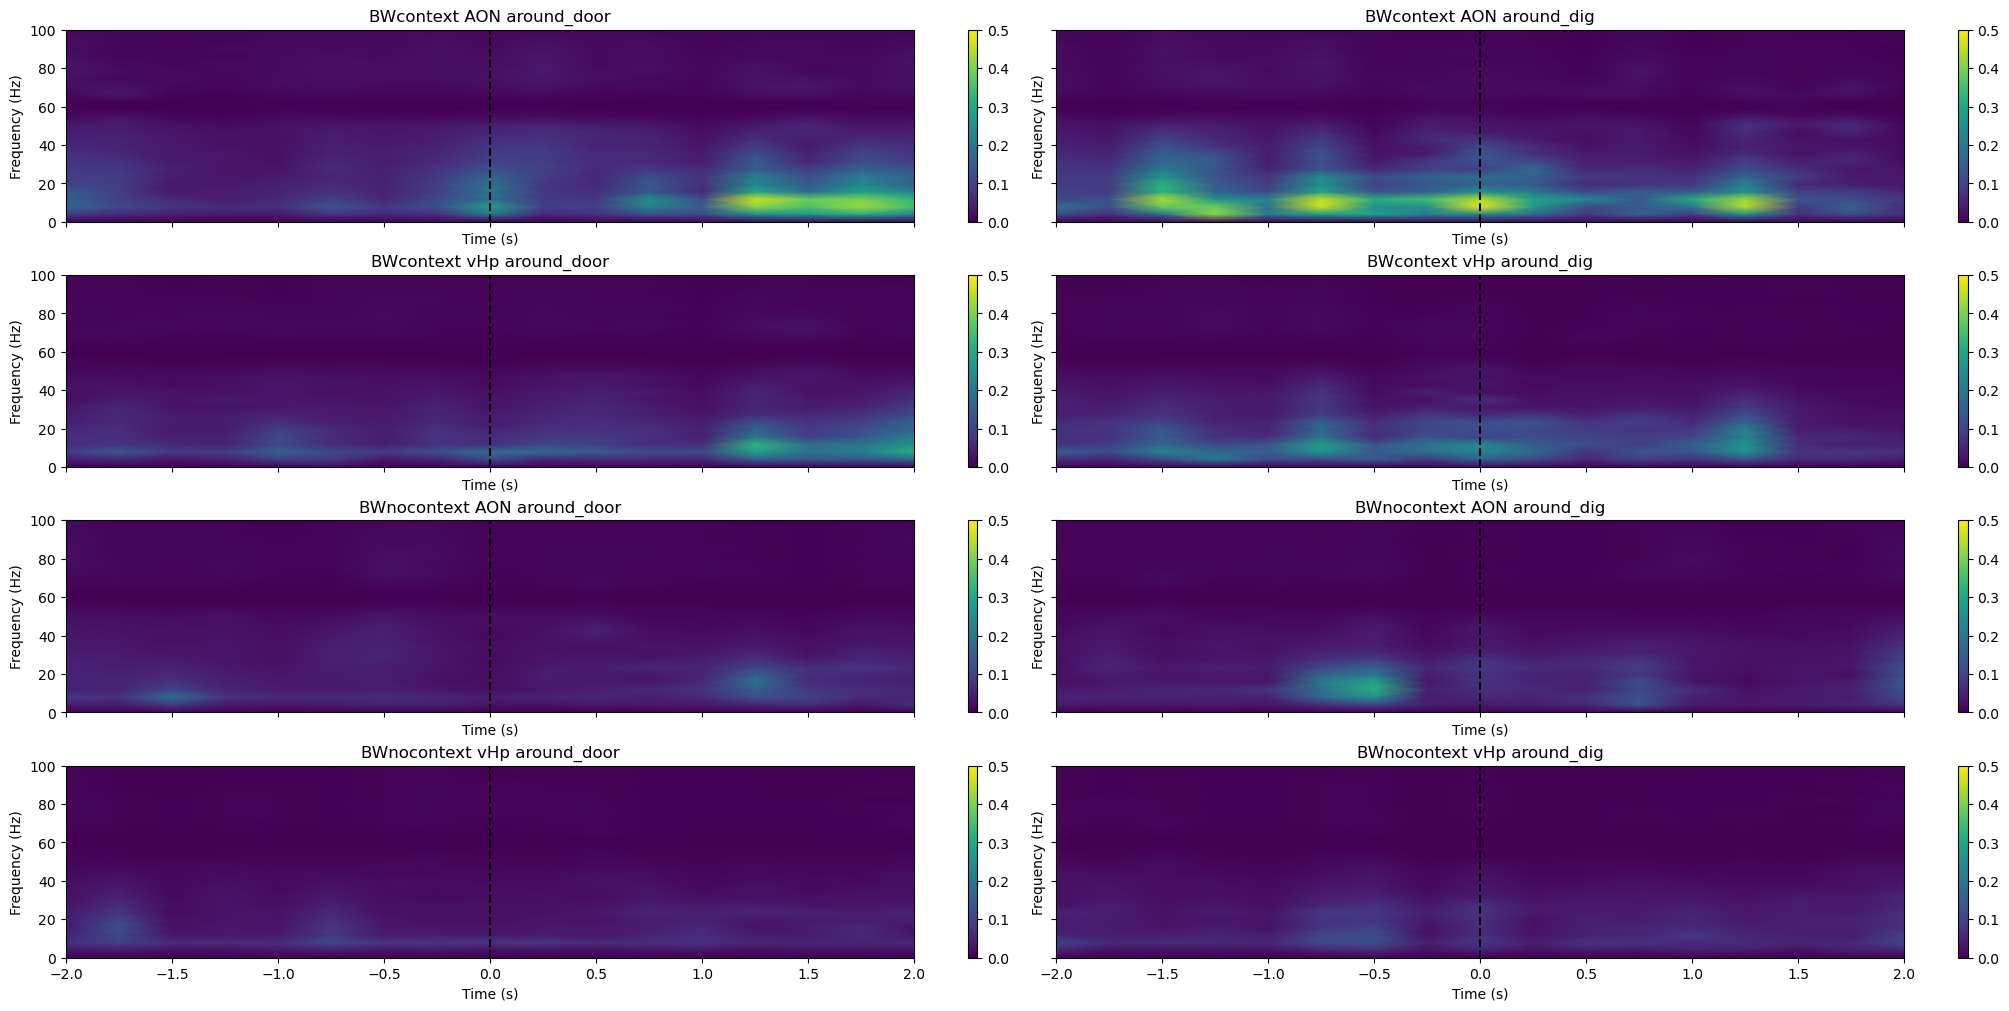

In [63]:
fig, axs = plt.subplots(4, 2, figsize=(20, 10), sharex=True, sharey=True, constrained_layout=True)
axs = axs.flatten()
power_spec_df['channel'] = power_spec_df['channel'].apply(lambda x: 'AON' if 'AON' in x else 'vHp')
power_spec_df_grouped = power_spec_df.groupby(['task', 'channel'])
i = 0
for (task, channel), group in power_spec_df_grouped:
    group = group.reset_index(drop=True)
    for col in ['around_door', 'around_dig']:
        data = np.array(group[col + '_sxx'])
        data_mean = np.mean(data, axis=0)
        print(data_mean.shape)
        freq = group[col + '_f'].iloc[0]
        time = group[col + '_t'].iloc[0]
        time_adjusted=np.linspace(-2,2,len(time))
        ax = axs[i]
        im = ax.pcolormesh(time_adjusted, freq, data_mean, shading='gouraud', vmin=0, vmax=0.5)
        fig.colorbar(im, ax=ax)
        ax.set_title(f'{task} {channel} {col}')
        ax.set_ylim(0, 100)
        # ax.set_xticks(np.arange(-2, 3, 1))  # Set x-ticks from -2 to 2 seconds
        # ax.set_xticklabels(np.arange(-2, 3, 1))  # Set x-tick labels from -2 to 2 seconds
        ax.vlines(0, 0, 100, color='k', linestyle='--')
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('Frequency (Hz)')
        i = i + 1
plt.show()


# 6. Coherence Measures

In [ ]:
import os
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mne
import mne_connectivity
#files=[f'C:\\Users\\{user}\\Dropbox\\CPLab\\all_data_mat\\20230616_dk6_BW_context_day2.mat']
event_data_df=[]
con_data_df=[]
shuffled_event_data_df=[]
events_codes_all = {}
random_baseline_data=[]
baseline_lfp_all=[]

for file_num,file in enumerate(files):
    #if 'dk1' in file:
        
        print(file)
        base_name = os.path.basename(file)
        base_name, _ = os.path.splitext(base_name)

        date, rat_id, task = functions.exp_params(base_name)
        print(date, rat_id, task)
        if task == 'nocontextday2' or task == 'nocontextos2':
            task = 'nocontext'
        if task =='nocontext':
            continue
        f = h5py.File(file, 'r')
        channels = list(f.keys())
        print(channels)
         
        if not any("AON" in channel or "vHp" in channel for channel in channels):
            print("No AON or vHp channels in this file")
            continue

        events,reference_electrode=functions.get_keyboard_and_ref_channels(f,channels)

    #finding global start and end time of all channels, since they start and end recordings at different times
        global_start_time, global_end_time=functions.find_global_start_end_times(f,channels)
        
        ## Reference electrode finding and padding
        reference_time = np.array(reference_electrode['times']).flatten()
        reference_value = np.array(reference_electrode['values']).flatten()
        padd_ref_data,padded_ref_time=functions.pad_raw_data_raw_time(reference_value,reference_time,global_start_time,global_end_time,sampling_rate=2000)

        events_codes = np.array(events['codes'][0])
        events_times = np.array(events['times'][0])
        events_codes_all[base_name] = events_codes
        epochs = functions.generate_epochs_with_first_event(events_codes, events_times)
        #epochs = functions.generate_specific_num_of_epochs_with_first_event(events_codes, events_times,5)
        aon_lfp_channels=[x for x in channels if 'AON' in x ]
        vHp_lfp_channels=[x for x in channels if 'vHp' in x ]
        all_channels=np.concatenate((aon_lfp_channels,vHp_lfp_channels))
        print(all_channels)
        
        mne_baseline_data=np.zeros((1,len(all_channels),4000))
        mne_epoch_door_before=np.zeros((len(epochs),len(all_channels),4000))
        mne_epoch_door_after=np.zeros((len(epochs),len(all_channels),4000))
        mne_epoch_dig_before=np.zeros((len(epochs),len(all_channels),4000))
        mne_epoch_dig_after=np.zeros((len(epochs),len(all_channels),4000))
        
        first_event = events_times[0]
        
        for channel_num,channeli in enumerate(all_channels):
            if "AON" in channeli or "vHp" in channeli:
                channel_id = channeli
                data_all = f[channeli]
                raw_data = np.array(data_all['values']).flatten()
                raw_time = np.array(data_all['times']).flatten()
                sampling_rate = int(1 / data_all['interval'][0][0])
                print(raw_data.shape, raw_time.shape, sampling_rate)
                
                padded_data,padded_time=functions.pad_raw_data_raw_time(raw_data,raw_time,global_start_time,global_end_time,sampling_rate)
                subtracted_data = padded_data - padd_ref_data
                raw_data=subtracted_data
                notch_filtered_data = functions.iir_notch(raw_data, sampling_rate, 60)
                
                data_before, time, baseline_mean, baseline_std=functions.baseline_data_normalization(notch_filtered_data, raw_time, first_event, sampling_rate)

                baseline_data_truncated= data_before[-4000:]
                
                mne_baseline_data[0,channel_num,:]=list(baseline_data_truncated)
                
                total = notch_filtered_data

                
                for i, epochi in enumerate(epochs):
                    door_timestamp = epochi[0][0]
                    trial_type = epochi[0][1]
                    dig_type = epochi[1, 1]
                    print(dig_type)
                    dig_timestamp = epochi[1, 0]
                    print(door_timestamp, trial_type, dig_timestamp, dig_type)
                    data_complete_trial = functions.extract_complete_trial_data(total, time, door_timestamp, dig_timestamp, sampling_rate)
                    #Here we will extract and store the events data
                    data_door_before,data_door_after=functions.extract_door_data(total, time, door_timestamp, sampling_rate)    
                    data_dig_before, data_dig_after=functions.extract_dig_data(total,time, dig_timestamp, sampling_rate)
                    event_data_list=[data_door_before,data_door_after,data_dig_before,data_dig_after]
                    [functions.zscore_event_data(event_data, baseline_mean ,baseline_std) for event_data in event_data_list]
                    mne_epoch_door_before[i,channel_num,:]=list(event_data_list[0])
                    mne_epoch_door_after[i,channel_num,:]=list(event_data_list[1])
                    mne_epoch_dig_before[i,channel_num,:]=list(event_data_list[2])
                    mne_epoch_dig_after[i,channel_num,:]=list(event_data_list[3])
        if len(all_channels)>0:
            fs=2000
            freqs = np.arange(1,100)
            n_cycles = freqs/2
            info = mne.create_info(ch_names=list(all_channels), sfreq=fs, ch_types='eeg')
            mne_baseline = mne.EpochsArray(mne_baseline_data, info)
            mne_epoch_door_before = mne.EpochsArray(mne_epoch_door_before, info)
            mne_epoch_door_after= mne.EpochsArray(mne_epoch_door_after, info)
            mne_epoch_dig_before = mne.EpochsArray(mne_epoch_dig_before, info)
            mne_epoch_dig_after = mne.EpochsArray(mne_epoch_dig_after, info)
            row_list=[file_num,rat_id,task,mne_baseline,mne_epoch_door_before,mne_epoch_door_after,mne_epoch_dig_before,mne_epoch_dig_after]
            con_data_df.append(row_list)

        # fs=2000
        # freqs = np.arange(1,100)
        # n_cycles = freqs/2
        # info = mne.create_info(ch_names=list(all_channels), sfreq=fs, ch_types='eeg')
        # mne_epoch_door_before = mne.EpochsArray(mne_epoch_door_before, info)
        # mne_epoch_door_after= mne.EpochsArray(mne_epoch_door_after, info)
        # mne_epoch_dig_before = mne.EpochsArray(mne_epoch_dig_before, info)
        # mne_epoch_dig_after = mne.EpochsArray(mne_epoch_dig_after, info)
        # row_list=[rat_id,task,mne_epoch_door_before,mne_epoch_door_after,mne_epoch_dig_before,mne_epoch_dig_after]
        # con_data_df.append(row_list)
#baseline_lfp_all = pd.DataFrame(baseline_lfp_all, columns=['rat', 'experiment', 'channel', 'data'])
con_data_df=pd.DataFrame(con_data_df, columns=['experiment','rat_id','task','mne_baseline','mne_epoch_door_before','mne_epoch_door_after','mne_epoch_dig_before','mne_epoch_dig_after'])


## 6.1 Baseline Coherence

## 6.2 Baseline Coherence Boxplots

In [ ]:
baseline_df=con_data_df.__deepcopy__()
baseline_df=baseline_df[baseline_df['rat_id']!='dk3']
baseline_df['mne_baseline']=baseline_df['mne_baseline'].apply(lambda x: functions.convert_epoch_to_coherence(x))

In [ ]:
fig, axs= plt.subplots(1, 1, figsize=(20, 10), sharex=True, sharey=True)
writer=pd.ExcelWriter(savepath+'baseline_coherence.xlsx')

event='mne_baseline'
event_data=baseline_df['mne_baseline']
event_data_df = pd.DataFrame(event_data.tolist())
event_data_df.reset_index(drop=True, inplace=True)
event_data_df['rat_id'] = baseline_df['rat_id'].reset_index(drop=True)
event_data_df['task'] = baseline_df['task'].reset_index(drop=True)
event_data_df_melted = pd.melt(event_data_df, id_vars=['rat_id', 'task'], value_vars=['total', 'theta', 'beta', 'gamma'], var_name='band', value_name='coherence')
sns.boxplot(x='band', y='coherence', hue='task', hue_order=['BWcontext', 'BWnocontext'], data=event_data_df_melted, showfliers=False, legend=False, ax=axs)
sns.stripplot(x='band', y='coherence', hue='task', hue_order=['BWcontext', 'BWnocontext'], data=event_data_df_melted, dodge=True, edgecolor='black', linewidth=1, jitter=True, legend=False, ax=axs)

#axs.set_xticklabels(['Total', 'Beta', 'Theta', 'Gamma'])
axs.set_title('Baseline Coherence')
axs.set_ylabel('Coherence')
axs.set_xlabel('')

event_data_df_melted.to_excel(writer, sheet_name=event)
writer.close()

fig.savefig(savepath+'baseline_coherence.png')
plt.show()


## 6.3 Coherence around events

In [ ]:


event_list=['mne_epoch_door_before','mne_epoch_door_after','mne_epoch_dig_before','mne_epoch_dig_after']

print(event_list)
con_data_df_clean=con_data_df[con_data_df['rat_id']!='dk3']
BWcontext_data=con_data_df[(con_data_df['task']=='BWcontext')]
BWnocontext_data=con_data_df[(con_data_df['task']=='BWnocontext')]
task_data_dict={'BWcontext':BWcontext_data,'BWnocontext':BWnocontext_data}


rat_list=np.unique(con_data_df['rat_id'])
print(rat_list)
all_con_data=[]
all_con_data_mean=[]
for task_num,task_name in enumerate(task_data_dict.keys()):
        task_data=task_data_dict[task_name]
    #print(task_name)
    # for rat_num, rat_name in enumerate(rat_list):
    #     rat_task_data=task_data[task_data['rat_id']==rat_name]
        row=[task_name]
    #     #print(row)
        row_2=[task_name]
        for event in event_list:
            #print(event)
            event_epoch_list=task_data[event]
            aon_vHp_con=[]
            for event_epoch in event_epoch_list:
                    #print(row,event, event_epoch) 
                    fmin=1
                    fmax=100
                    freqs = np.arange(fmin,fmax)
                    n_cycles = freqs/2
                           
                    con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),
                                                         mode='cwt_morlet', cwt_freqs=freqs,
                                                         cwt_n_cycles=n_cycles, verbose=False, fmin=1, fmax=100, faverage=False)
                    coh = con.get_data(output='dense')
                    indices = con.names
                    

                    for i in range(coh.shape[0]):
                        for j in range(coh.shape[1]):
                            if 'AON' in indices[j] and 'AON' in indices[i]:
                                aon_vHp_con.append(coh[i,j,:,:])
            row.append(np.mean(aon_vHp_con, axis=0))
            row_2.append(np.mean(aon_vHp_con))
        all_con_data.append(row)                    
        all_con_data_mean.append(row_2)
# Convert all_con_data to a DataFrame for easier manipulation
all_con_data_df = pd.DataFrame(all_con_data, columns=['task'] + event_list)

fs=2000


times=np.arange(0, 2, 1/fs)
fig, axs=plt.subplots(2,4, figsize=(20,10), sharey=True)
vmin = all_con_data_df[event_list].applymap(np.min).min().min()
vmax = all_con_data_df[event_list].applymap(np.max).max().max()
event_names=['Before Door','After Door','Before Dig','After Dig']
for i, event in enumerate(event_list):
    axs[0,i].imshow(all_con_data_df[event][0], extent=[times[0], times[-1], 1, 100],
                   aspect='auto', origin='lower', cmap='jet', vmin=vmin, vmax=vmax)
    axs[0,i].set_xlabel('Time (s)')
    axs[0,i].set_ylabel('Frequency (Hz)')
    axs[0,i].set_title(event_names[i])

    axs[1,i].imshow(all_con_data_df[event][1], extent=[times[0], times[-1], 1, 100],
                   aspect='auto', origin='lower', cmap='jet', vmin=vmin, vmax=vmax)
    axs[1,i].set_xlabel('Time (s)')
    axs[1,i].set_ylabel('Frequency (Hz)')
    axs[1,i].set_title(event_names[i])
    axs[0,0].text(-0.3, 0.5, 'BW Context', transform=axs[0,0].transAxes, fontsize=14, verticalalignment='center', rotation=90)
    axs[1,0].text(-0.3, 0.5, 'BW No Context', transform=axs[1,0].transAxes, fontsize=14, verticalalignment='center', rotation=90)
    # Add a colorbar
cbar = fig.colorbar(axs[0,0].images[0], ax=axs, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('Coherence')
fig.savefig(f'C:\\Users\\{user}\\Dropbox\\CPLab\\results\\aon_aon_coherence_event_spectrogram.png', dpi=300)
plt.show()

## 6.4 Coherence around events Boxplots 

In [ ]:
import seaborn as sns
con_data_df_clean=con_data_df[con_data_df['rat_id']!='dk3']
con_data_df_clean=con_data_df_clean[con_data_df_clean['task']!='nocontext']

rat_list=['dk1', 'dk5', 'dk6']


single_baseline_epoch=con_data_df_clean['mne_epoch_door_before'].iloc[0]
theta_band=[4,8]

theta_coherence=functions.convert_epoch_to_coherence(single_baseline_epoch)
print(theta_coherence)

con_data_df_clean['coherence_door_before']=con_data_df_clean['mne_epoch_door_before'].apply(lambda x: functions.convert_epoch_to_coherence(x))
con_data_df_clean['coherence_door_after']=con_data_df_clean['mne_epoch_door_after'].apply(lambda x: functions.convert_epoch_to_coherence(x))
con_data_df_clean['coherence_dig_before']=con_data_df_clean['mne_epoch_dig_before'].apply(lambda x: functions.convert_epoch_to_coherence(x))
con_data_df_clean['coherence_dig_after']=con_data_df_clean['mne_epoch_dig_after'].apply(lambda x: functions.convert_epoch_to_coherence(x))


In [ ]:

fig, axs = plt.subplots(2, 2, figsize=(20, 10))
axs = axs.flatten()
writer=pd.ExcelWriter(f'C:\\Users\\{user}\\Dropbox\\CPLab\\results\\coherence_event_per_band.xlsx')
for i, event in enumerate(['coherence_door_before', 'coherence_door_after', 'coherence_dig_before', 'coherence_dig_after']):
    event_data = con_data_df_clean[event]
    event_data_df = pd.DataFrame(event_data.tolist())
    event_data_df.reset_index(drop=True, inplace=True)
    event_data_df['rat_id'] = con_data_df_clean['rat_id'].reset_index(drop=True)
    event_data_df['task'] = con_data_df_clean['task'].reset_index(drop=True)
    event_data_df_melted = pd.melt(event_data_df, id_vars=['rat_id', 'task'], value_vars=['total', 'theta', 'beta', 'gamma'], var_name='band', value_name='coherence')
    sns.boxplot(x='band', y='coherence', hue='task', hue_order=['BWcontext', 'BWnocontext'], data=event_data_df_melted, showfliers=False, legend=False, ax=axs[i])
    sns.stripplot(x='band', y='coherence', hue='task', hue_order=['BWcontext', 'BWnocontext'], data=event_data_df_melted, dodge=True, edgecolor='black', linewidth=1, jitter=True, legend=False, ax=axs[i])
    axs[i].set_xticklabels(['Total', 'Beta', 'Theta', 'Gamma'])
    axs[i].set_title(event)
    axs[i].set_ylabel('Coherence')
    axs[i].set_xlabel('')
    event_data_df_melted.to_excel(writer, sheet_name=event)
writer.close()
# Create custom legend handles and labels
from matplotlib.lines import Line2D
colors = {'BWnocontext': '#ff7f0e', 'BWcontext': '#1f77b4'}

# Create custom legend handles and labels
handles = [
    Line2D([0], [0], color=colors['BWcontext'], marker='o', linestyle='', markersize=10, label='BWcontext'),
    Line2D([0], [0], color=colors['BWnocontext'], marker='o', linestyle='', markersize=10, label='BWnocontext')
]

# Add the custom legend to the figure
fig.legend(handles=handles, loc='upper right', bbox_to_anchor=(1.1, 1), title='Task')
fig.savefig(f'C:\\Users\\{user}\\Dropbox\\CPLab\\results\\coherence_event_per_band.png', dpi=300)
plt.tight_layout()
plt.show()


In [ ]:
event_data = con_data_df_clean.__deepcopy__()
event_data.drop(columns=['mne_baseline', 'mne_epoch_door_before', 'mne_epoch_door_after', 'mne_epoch_dig_before', 'mne_epoch_dig_after'], inplace=True)
event_data = event_data[event_data['rat_id'] != 'dk3']
def unravel_dicts_to_df(df, cols):
    for col in cols:
        df = df.join(pd.json_normalize(df[col], sep='_', errors='Raise'), rsuffix=f'_{col}')
        df.drop(columns=[col], inplace=True)
    return df
event_data_unravel = unravel_dicts_to_df(event_data, ['coherence_door_before', 'coherence_door_after', 'coherence_dig_before', 'coherence_dig_after'])
#event_data_unravel = unravel_dicts_to_df(event_data, ['coherence_door_before', 'coherence_door_after', 'coherence_dig_before', 'coherence_dig_after'])


# event_data = event_data.apply(lambda x: x.explode() if isinstance(x, list) else x)

# # Convert the dictionary columns to separate columns
# for col in ['coherence_door_before', 'coherence_door_after', 'coherence_dig_before', 'coherence_dig_after']:
# 	event_data = event_data.join(pd.json_normalize(event_data[col], sep='_'), rsuffix=f'_{col}')
# 	event_data.drop(columns=[col], inplace=True)
#     # Rename columns to add the '_door_before' suffix where missing
# event_data.rename(columns={
#     'theta': 'theta_coherence_door_before',
#     'beta': 'beta_coherence_door_before',
#     'gamma': 'gamma_coherence_door_before',
#     'total': 'total_coherence_door_before'
# }, inplace=True)
# print(event_data.head())
    